In [1]:
print("""
@Description: Evaluation metrics for classification
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-07-16 14:31:22
""")


@Description: Evaluation metrics for classification
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-07-16 14:31:22



In [14]:
import pandas as pd
import numpy as np
df = pd.read_csv('../Ch03_churn_prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df['churn'] = (df['churn'] == 'yes').astype(int)
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=.2, 
                                          random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=.33, random_state=1)
y_train = df_train['churn'].values
y_val = df_val['churn'].values
del df_train['churn']
del df_val['churn']
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']
train_dict = df_train[categorical + numerical].to_dict(orient='records')
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
x_train = dv.transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

from sklearn.linear_model import  LogisticRegression
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(x_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

## Evaluation metrics

### Classification accuracy

In [15]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred > .5
(churn == y_val).mean()

0.8059139784946237

In [20]:
from sklearn.metrics import accuracy_score
thresholds = np.linspace(0, 1, 11)
for threshold in thresholds:
    churn = y_pred >= threshold
    acc = accuracy_score(y_val, churn)
    print(f'threshold={threshold:.2f}, acc.={acc:.3f}')

threshold=0.00, acc.=0.269
threshold=0.10, acc.=0.589
threshold=0.20, acc.=0.692
threshold=0.30, acc.=0.749
threshold=0.40, acc.=0.782
threshold=0.50, acc.=0.806
threshold=0.60, acc.=0.804
threshold=0.70, acc.=0.773
threshold=0.80, acc.=0.744
threshold=0.90, acc.=0.731
threshold=1.00, acc.=0.731


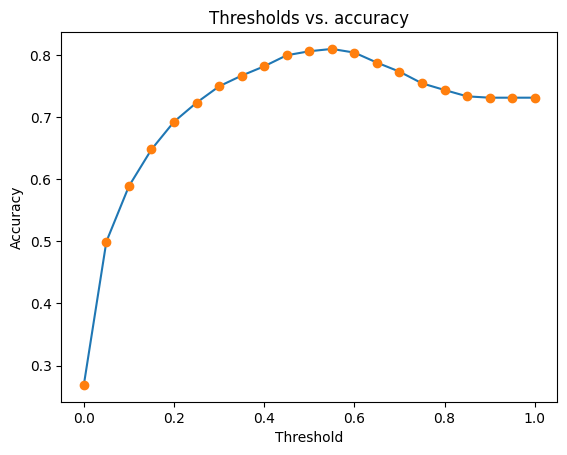

In [29]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for threshold in thresholds:
    acc = accuracy_score(y_val, y_pred >= threshold)
    accuracies.append(acc)
import matplotlib.pyplot as plt
plt.plot(thresholds, accuracies)
plt.plot(thresholds, accuracies, 'o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Thresholds vs. accuracy')
plt.show()

In [31]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
X_small_train = dv_small.fit_transform(train_dict_small)
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [35]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_train = dv_small.transform(val_dict_small)
y_pred_small = model_small.predict_proba(X_small_train)[:, 1]
churn_small = y_pred_small >= .5
accuracy_score(y_val, churn_small)

0.7327956989247312

### Dummy baseline

In [37]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
accuracy_score(baseline, y_val)

0.7311827956989247

## Confusion table

### Calculating the confusion table with NumPy

In [45]:
t = .5
predict_churn = (y_pred >= t)
# predict_no_churn = ~predict_churn
predict_no_churn = (y_pred < t)

actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

true_negative = (predict_no_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()

In [48]:
confuse_table = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])
confuse_table

array([[1224,  136],
       [ 225,  275]])

## ROC curve and AUC score

### Evaluating a model at multiple thresholds

In [57]:
scores = []
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    tp = ((y_pred >= threshold) & (y_val == 1)).sum()
    tn = ((y_pred < threshold) & (y_val == 0)).sum()
    fp = ((y_pred >= threshold) & (y_val == 0)).sum()
    fn = ((y_pred < threshold) & (y_val == 1)).sum()
    scores.append((threshold, tp, fp, fn, tn))
    
df_scores = pd.DataFrame(scores, columns=['threshold', 'TP', 'FP', 'FN', 'TN'])
df_scores['TPR'] = df_scores['TP'] / (df_scores['TP'] + df_scores['FN'])
df_scores['FPR'] = df_scores['FP'] / (df_scores['FP'] + df_scores['TN'])
df_scores

,threshold,TP,FP,FN,TN,TPR,FPR
0,0.00,500,1360,0,0,1.000,1.000000
1,0.01,500,1254,0,106,1.000,0.922059
2,0.02,497,1130,3,230,0.994,0.830882
3,0.03,495,1047,5,313,0.990,0.769853
4,0.04,493,976,7,384,0.986,0.717647
...,...,...,...,...,...,...,...
96,0.96,0,0,500,1360,0.000,0.000000
97,0.97,0,0,500,1360,0.000,0.000000
98,0.98,0,0,500,1360,0.000,0.000000
99,0.99,0,0,500,1360,0.000,0.000000


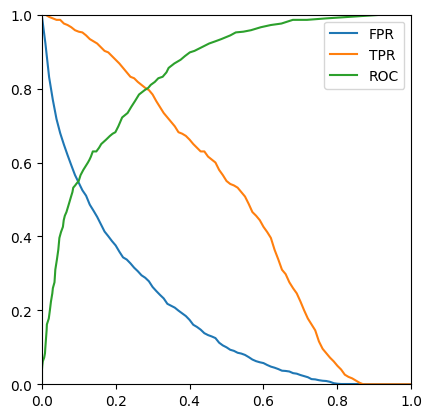

In [74]:
plt.plot(df_scores['threshold'], df_scores['FPR'], label='FPR')
plt.plot(df_scores['threshold'], df_scores['TPR'], label='TPR')
plt.plot(df_scores['FPR'], df_scores['TPR'], label='ROC')
plt.legend()
ax = plt.gca()
ax.set_aspect('equal', 'box')
plt.axis([0, 1, 0, 1])
plt.show()

In [76]:
import sys
sys.path.append('../')
sys.path.append('./')
from utils.funs import tpr_fpr_dataframe

### Random baseline model

In [81]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,Threshold,TP,FP,FN,TN,TPR,FPR
0,0.0,500,1360,0,0,1.000,1.000000
10,0.1,447,1229,53,131,0.894,0.903676
20,0.2,397,1096,103,264,0.794,0.805882
30,0.3,350,961,150,399,0.700,0.706618
40,0.4,303,834,197,526,0.606,0.613235
50,0.5,261,701,239,659,0.522,0.515441
60,0.6,211,561,289,799,0.422,0.412500
70,0.7,162,412,338,948,0.324,0.302941
80,0.8,107,293,393,1067,0.214,0.215441
90,0.9,56,148,444,1212,0.112,0.108824


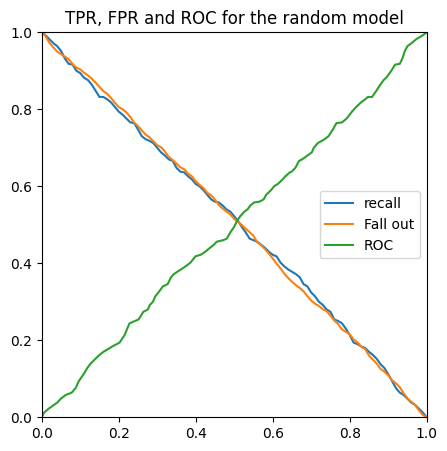

In [90]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.plot(df_rand['Threshold'], df_rand['TPR'], label='recall')
ax.plot(df_rand['Threshold'], df_rand['FPR'], label='Fall out')
ax.plot(df_rand['FPR'], df_rand['TPR'], label='ROC')
ax.set_aspect('equal', 'box')
ax.legend()
ax.set_title('TPR, FPR and ROC for the random model')
ax.axis([0, 1, 0, 1])
plt.show()

### The ideal model

In [97]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

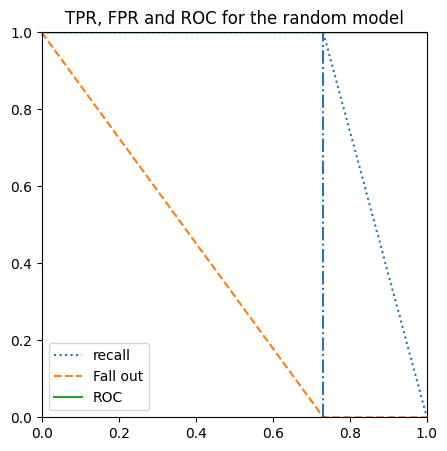

In [104]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.plot(df_ideal['Threshold'], df_ideal['TPR'], label='recall', linestyle=':')
ax.plot(df_ideal['Threshold'], df_ideal['FPR'], label='Fall out', linestyle='--')
ax.axvline(x=.73, linestyle='-.')
ax.plot(df_ideal['FPR'], df_ideal['TPR'], label='ROC')
ax.set_aspect('equal', 'box')
ax.legend()
ax.set_title('TPR, FPR and ROC for the random model')
ax.axis([0, 1, 0, 1])
plt.show()

### ROC Curve

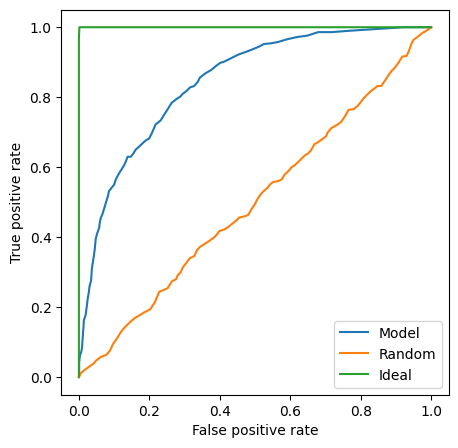

In [108]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores['FPR'], df_scores['TPR'], label='Model')
plt.plot(df_rand['FPR'], df_rand['TPR'], label='Random')
plt.plot(df_ideal['FPR'], df_ideal['TPR'], label='Ideal')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

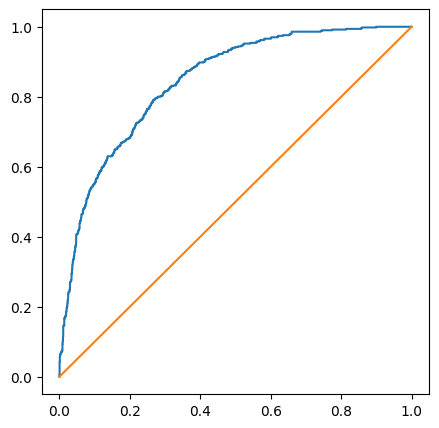

In [111]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

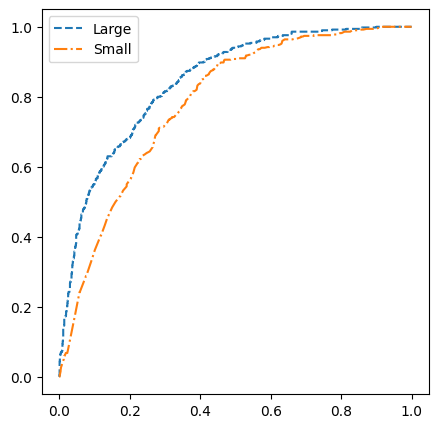

In [121]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)
plt.figure(figsize=(5, 5))

plt.plot(fpr_large, tpr_large, label='Large', linestyle='--')
plt.plot(fpr_small, tpr_small, label='Small', linestyle='-.')
plt.legend()
plt.show()

### Area under the ROC curve (AUC)

In [124]:
from sklearn.metrics import auc
auc(fpr_large, tpr_large)

0.8440992647058823

In [125]:
auc(fpr_small, tpr_small)

0.7822433823529413

In [126]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8440992647058823

In [127]:
roc_auc_score(y_val, y_pred_small)

0.7822433823529413

In [138]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
# Randomly selects 10,000 scores of negative examples (non-churning customers)
neg_choice = np.random.randint(low=0, high=len(neg), size=10_000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10_000)

In [139]:
# For each of the positive examples, checks if the score is higher than the respective negative example
(pos[pos_choice] > neg[neg_choice]).mean()

0.8411